- make a colored header for the diagnostic plots and original data display
- make max components function
- create the 3D bivariate plot
- add an option for categorical color coding
- add functionality to the plots to select various eigenvectos to display

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%config InlineBackend.figure_format = 'retina'

# Definitions

In [2]:
def calculate_principal_components(data):
    
    pca = PCA()
    p_components = pca.fit_transform(data)
    p_components = pd.DataFrame(p_components)

    # Add the principal component columns
    p_components.columns = p_components.columns+1
    p_components = p_components.add_prefix('Principal Component ')
    
    return p_components

In [3]:
def create_eigenvalues_matrix(data, styled=True, threshold=0.05):
    #TODO: Create an eigenvalues column.
    
    pca = PCA()
    p_components = pca.fit_transform(data)
    
    # Explained Variance (Eigenvalues)
    eigenvalues = pca.explained_variance_

    # Explained Variance Ratios
    ev_ratios = pca.explained_variance_ratio_

    # Eigenvalues Matrix
    ev_matrix = pd.DataFrame({'eigenvalues':eigenvalues, 'ev_ratios':ev_ratios, 'cum_percent':ev_ratios.cumsum()*100})
    
    if styled==False:
        return ev_matrix

    def color_eigenvalues(val):

        if abs(val) >= 1:
            color = 'dodgerblue'
            fontweight = 'bold'
     
        else:
            color = "black"
            fontweight = 'medium'
        return "color: %s" % color

    def color_cum_percent(val):
        
        # If the threshold yields greater than 99% of all values
        if 100*(1-threshold) >= 99:
            
            if abs(val) <= 100*(1-threshold):
                color = "dodgerblue"
                fontweight = 'bold'
            else:
                color = "black"
                fontweight = 'medium'
            
        else:     

            if abs(val) <= 100*(1-threshold):
                color = 'dodgerblue'
                fontweight = 'bold'
            elif (abs(val) >= 100*(1-threshold) and abs(val) < 99):
                color='cadetblue'
                fontweight = 'bold'       
            else:
                color = "black"
                fontweight = 'medium'
            return "color: %s" % color
    
    styled_ev_matrix = ev_matrix.style.set_properties(**{"text-align": "center"})
    styled_ev_matrix = styled_ev_matrix.applymap(color_eigenvalues, subset=['eigenvalues'])
    styled_ev_matrix = styled_ev_matrix.applymap(color_cum_percent, subset=['cum_percent'])

    return styled_ev_matrix        

In [4]:
def create_covariance_matrix(data, styled=True):

    pca = PCA()
    pca.fit_transform(data)
    covariance_matrix = pd.DataFrame(pca.get_covariance())
    covariance_matrix.columns = data.columns
    covariance_matrix.index = data.columns   
    
    if styled==False:
        return covariance_matrix 
    
    styled_covariance_matrix = covariance_matrix.style.set_properties(**{"text-align": "center"})

    return styled_covariance_matrix    

In [5]:
def create_eigenvectors_matrix(data, styled=True):
    
    pca = PCA()
    pca.fit_transform(data)
    p_components = pca.fit_transform(data)
    p_components = pd.DataFrame(p_components)    
    p_components.columns = p_components.columns+1
    p_components = p_components.add_prefix('Principal Component ')
    
    eigenvectors = pd.DataFrame(pca.components_)
    eigenvectors.columns = p_components.columns
    eigenvectors.index = data.columns
    
    if styled==False:
        return eigenvectors

    def color_eigenvectors(val):

        if abs(val) >= 0.5:
            color = "dodgerblue"
            fontweight = 'bold'
        elif (abs(val) >= 0.25) and (abs(val) < 0.5):
            color="cadetblue"
            fontweight = 'bold'
        else:
            color = "black"
            fontweight = 'medium'
        return "color: %s" % color

    styled_eigenvectors = eigenvectors.style.set_properties(**{"text-align": "center"})

    for pc in range(1,len(eigenvectors.columns)+1):
        styled_eigenvectors = styled_eigenvectors.applymap(color_eigenvectors, subset=[f'Principal Component {pc}'])

    return styled_eigenvectors

In [6]:
def create_pca_loading_plot(data, comp_a=1, comp_b=2, figsize=(7,7), solo_plot=True, ax=None):

    if solo_plot is True and ax is None:
        ax = None
    elif solo_plot is False and ax is None:
        ax=plt.gca()

    eigenvectors = create_eigenvectors_matrix(data, styled=False)
    ev_matrix = create_eigenvalues_matrix(data, styled=False)

    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)

    eigen_x_val = eigenvectors[f"Principal Component {comp_a}"]
    eigen_y_val = eigenvectors[f"Principal Component {comp_b}"]

    # Add circle
    circ = plt.Circle((0, 0), 1, color='dodgerblue', fill=False)
    ax.add_patch(circ)

    # X and Y axis
    ax.axhline(y=0, linestyle = '--', color = 'dodgerblue', linewidth = 0.5)
    ax.axvline(x=0, linestyle = '--', color = 'dodgerblue', linewidth = 0.5)

    # Draw arrows and annotate
    for i, row in eigenvectors.iterrows():

        # plot arrow
        ax.arrow(
            0, 0, 
            row[f"Principal Component {comp_a}"], row[f"Principal Component {comp_b}"], 
            color = 'dodgerblue', 
            length_includes_head = True,
            head_width = 0.05,
            shape = 'right',
            linewidth = 1, 
        )

        if row[f"Principal Component {comp_b}"]<=0: vert_adj = -0.075
        else: vert_adj = 0.05

        ax.text(
            row[f"Principal Component {comp_a}"]-0.2, row[f"Principal Component {comp_b}"]+vert_adj,
            i
        )
    # Scatterplot    
    ax.scatter(eigen_x_val, eigen_y_val, marker="o", s = 70, color="grey", ec="k", alpha=1, label = 'Data')

    # Max/ Min
    ax.set_xlim(-1.20, 1.20)
    ax.set_ylim(-1.20, 1.20)

    # Labels and Title
    ax.set_xlabel(f"\nComponent {comp_a}  ({(round(ev_matrix.iloc[comp_a-1]['ev_ratios'],3))*100}%)")
    ax.set_ylabel(f"Component {comp_b}  ({(round(ev_matrix.iloc[comp_b-1]['ev_ratios'],3))*100}%)\n")
    ax.set_title('Loading Plot\n')
    
    if solo_plot is True:
        plt.show()
        plt.close()
        return 

    return ax

In [7]:
def create_pca_score_plot(data, comp_a=1, comp_b=2, figsize=(7,7), solo_plot=True, ax=None):
    
    # Grab the current axis if none provided. 
    if solo_plot is True and ax is None:
        ax = None
    elif solo_plot is False and ax is None:
        ax=plt.gca()
        
    # Get principal components and eigenvectors
    p_components = calculate_principal_components(data)
    ev_matrix = create_eigenvalues_matrix(data, styled=False)

    x_val = p_components[f"Principal Component {comp_a}"]
    y_val = p_components[f"Principal Component {comp_b}"]

    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)

    # Some styles only make sense if the number of points to plot
    # are below certain thresholds...
    marker = "o" if len(p_components ) < 50 else "."
    ax.scatter(x_val, y_val, marker=marker, s = 70, color="grey", ec="k", alpha=0.5, label = 'Data')

    # X and Y axis
    ax.axhline(y=0, linestyle = '-', color = 'dodgerblue', linewidth = 0.5)
    ax.axvline(x=0, linestyle = '-', color = 'dodgerblue', linewidth = 0.5)

    # Max/ Min
    x_limit = max(abs(x_val.min()), abs(x_val.max()))*1.20
    ax.set_xlim(-x_limit, x_limit)
    y_limit = max(abs(y_val.min()), abs(y_val.max()))*1.20
    ax.set_ylim(-y_limit, y_limit)

    # Labels and Title
    ax.set_xlabel(f"\nComponent {comp_a}  ({(round(ev_matrix.iloc[comp_a-1]['ev_ratios'],3))*100}%)")
    ax.set_ylabel(f"Component {comp_b}  ({(round(ev_matrix.iloc[comp_b-1]['ev_ratios'],3))*100}%)\n")
    ax.set_title('Score Plot\n')
    
    if solo_plot is True:
        plt.show()
        plt.close()
        return 
    
    return ax

In [8]:
def create_pca_explained_variance_plot(data, max_eigenvals=10, figsize=(7,7), solo_plot=True, ax=None):
    
    # Grab the current axis if none provided. 
    if solo_plot is True and ax is None:
        ax = None
    elif solo_plot is False and ax is None:
        ax=plt.gca()
    
    ev_matrix = create_eigenvalues_matrix(data, styled=False)

    # Set the max number of eigenvalues to show on the Pareto plot
    num_eigenvals_to_show = len(ev_matrix)
    max_threshold = False

    if num_eigenvals_to_show > max_eigenvals:
        max_threshold = True
        num_eigenvals_to_show = max_eigenvals-1

    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)

    # Get the most recent values for a bar plot up to the max eigenvalues
    eigenvalues = ev_matrix['eigenvalues'][0:(num_eigenvals_to_show + 1)].sort_values(ascending=False)  # only take the first 10 eigenvalues
    ev_ratios = ev_matrix['ev_ratios'][0:(num_eigenvals_to_show + 1)].sort_values(ascending=False)*100
    cum_percent = ev_matrix['cum_percent'][0:(num_eigenvals_to_show + 1)].sort_values(ascending=True)

    # Append missing values if there are less than '(num_eigenvals_to_show + 1)'
    if (num_eigenvals_to_show + 1)-len(eigenvalues) > 0:

        blank_vals = list(np.full((1,(num_eigenvals_to_show + 1)-len(eigenvalues)), fill_value = '')[0])
        y_labels = round(ev_ratios,2).append(pd.Series(blank_vals))
        y_labels =[f'{val}%' if '' != val else '' for val in y_labels]

        zero_vals = list(np.full((1,(num_eigenvals_to_show + 1)-len(eigenvalues)), fill_value = 0)[0])
        y_nums = ev_ratios.append(pd.Series(zero_vals))

    y_vals = np.arange((num_eigenvals_to_show + 1)-1,-1,-1)

    # Make the bar plot, cumulative percentage plots, etc. 
    ax.barh(y_vals, y_nums[0:len(y_vals)], align='center', color = 'lightgrey', edgecolor = 'dodgerblue', alpha=1, label = 'Percent Per Principal Component')
    ax.plot(cum_percent, y_vals[:len(cum_percent)], linestyle = '--', label = 'Cumulative Percent')

    # X Axis Ticker Format
    fmt = '{x:,.0f}%'
    tick = mpl.ticker.StrMethodFormatter(fmt)
    ax.xaxis.set_major_formatter(tick)

    # X limit
    ax.set_xlim(0,100)

    # Title changes to alert user of missing eigenvalues if the max threshold is less than the number eigenvalues available. 
    if max_threshold:  # missing eigenvalues because there are more than the max threshold
        not_shown = len(ev_matrix)-max_eigenvals
        ax.set_title(f'Explained Variance-Pareto Plot\n{num_eigenvals_to_show+1} Eigenvalues\n{not_shown} Eigenvalue(s) not displayed.\n')
        ax.set_ylim(-1,(num_eigenvals_to_show + 1))

    else:
        ax.set_title(f'Explained Variance-Plot\n{num_eigenvals_to_show} Eigenvalues\n') 
        ax.set_ylim(0,(num_eigenvals_to_show + 1))

    ax.set_xlabel('\nPercent of Variation and Cummulative Percent\n')

    # Set Y values and tick lables
    ax.set_ylabel(f'Each Principal Component (PC)\n')
    ax.set_yticks(y_vals)

    # Make sure to label the principal components corresponding to the Eigenvalues
    new_y_labels = []
    for count in range(1, len(y_labels)+1):
        new_val = f'PC {count}'

        if count == len(y_labels):
            new_y_labels.append('')
        else:
            new_y_labels.append(new_val)
        ax.text(3,count-0.04, y_labels[len(y_labels)-count-1], fontsize = 14)

    ax.set_yticklabels(new_y_labels[0:len(y_vals)])
    ax.grid(axis="x")
    ax.legend(loc = 3)
    
    if solo_plot is True:
        plt.show()
        plt.close()
        return 
    
    return ax

In [9]:
def create_pca_scree_plot(data, max_eigenvals = 10, figsize=(7,7), solo_plot=True, ax=None):
    
    # Grab the current axis if none provided. 
    if solo_plot is True and ax is None:
        ax = None
    elif solo_plot is False and ax is None:
        ax=plt.gca()
        
    # Get principal Components
    pca = PCA()
    p_components = pca.fit_transform(data)

    # Explained Variance (Eigenvalues)
    eigenvalues = pca.explained_variance_

    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)

    # Some styles only make sense if the number of points to plot
    # are below certain thresholds...
    marker = "o" if len(eigenvalues) < 50 else "."
    ax.scatter(
        np.arange(0,(len(eigenvalues)))[0:max_eigenvals], 
        eigenvalues[0:max_eigenvals],
        marker=marker, 
        s = 70, 
        color="grey", ec="k", alpha=1, 
        label = 'Eigenvalue'
    )
    ax.plot(eigenvalues[0:max_eigenvals], color = 'dodgerblue', linewidth = 1)

    # Plot Eigenvalues

    for i in range(0,len(eigenvalues)):
        val = round(eigenvalues[i],4)
        text_loc_y = val+0.1
        text_loc_x = i-0.25
        ax.text(text_loc_x, text_loc_y, val, fontsize = 14)

    ax.axhline(y=1, color = 'dodgerblue', linestyle = '--', label='Kaiser Rule')
    ax.set_ylim(-0.5, np.max(eigenvalues)*1.15)
    ax.set_xlim(-0.5, len(eigenvalues)-0.5)

    ax.set_title('Scree Plot:\nEigenvalues Per Principal Component\n')
    ax.set_ylabel('Eigenvalues\n')
    ax.set_xlabel('\nEach Principal Component (PC)')

    ax.set_xticks(np.arange(0, len(eigenvalues))[0:max_eigenvals])
    ax.set_xticklabels([f'PC {val}' for val in np.arange(1,len(eigenvalues)+1)][0:max_eigenvals])
    ax.legend()
    
    if solo_plot is True:
        plt.show()
        plt.close()
        return 
    
    return ax



In [10]:
def display_pca_diagnostic_plots(data, figsize=(10,10), headspace=1):
    
    fig, axes = plt.subplots(2,2, figsize=figsize, constrained_layout=True)
    funcs = [
        create_pca_explained_variance_plot,
        create_pca_scree_plot,
        create_pca_loading_plot,
        create_pca_score_plot
    ]
    
    for ax, f in zip(axes.flatten(), funcs):
        
        f(data,solo_plot=False, ax=ax)
        
    plt.show()    

In [11]:
def create_dataframe_subtitle(title_text, color="dodgerblue", fontsize=18, fontweight="bold", display_title=True):
    #TODO: Fix the word wrapping inthe title by getting rid of the underline in the dataframe
    
    subtitle = pd.DataFrame().style.set_properties()
    subtitle = subtitle.set_caption(title_text).set_table_styles(
        [
            {
                "selector": "caption",
                "props": [
                    ("color", color),
                    ("font-size", f"{fontsize}px"),
                    ("font-weight:", fontweight),
                ],
            }
        ]
    )
    if display_title is True:
        display(subtitle)
    else:
        return subtitle

In [12]:
def conduct_pca(
    data,
    display_eigenvalues=True,
    display_covariances=True,
    display_eigenvectors=True,
    display_diagnostic_plots=True,
    display_principal_components_data=False,
    return_principal_components_only=False
               ):

    # Eigenvalues Matrix
    if display_eigenvalues:  
        create_dataframe_subtitle("Eigenvalues Matrix")
        ev_matrix = create_eigenvalues_matrix(data)
        display(ev_matrix)

    # Covariance Matrix
    if display_covariances:
        create_dataframe_subtitle("Covariance Matrix")
        display(create_covariance_matrix(data))   

    # Egenvectors
    if display_eigenvectors:
        create_dataframe_subtitle("Eigenvectors")
        display(create_eigenvectors_matrix(data))  

    # Diagnostic Plots
    if display_diagnostic_plots:
        create_dataframe_subtitle("Diagnostic Plots")
        display_pca_diagnostic_plots(data, figsize=(12,12))

    # Principal Components
    p_components = calculate_principal_components(data)
    output_data = pd.concat([data,p_components], axis = 1)

    if display_principal_components_data:
        # Dislpay Principal Component Values
        create_dataframe_subtitle("Data with Principal Components")
        display(output_data)

    if return_principal_components_only:
        return p_components

    return output_data

# Main

## Load Data

In [13]:
# Load IRIS Data into a dataframe
from sklearn import datasets
iris = datasets.load_iris()    
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])

# Target and Data
y = df['target']
X = df[[col for col in df.columns if col not in ['target']]]

In [14]:
# Settings
# TODO: Need to make a max components funciton...
n_components = None
data = X.copy()

## Run PCA

,eigenvalues,ev_ratios,cum_percent
0,4.228242,0.924619,92.461872
1,0.242671,0.053066,97.768521
2,0.078210,0.017103,99.478782
3,0.023835,0.005212,100.000000


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),0.685694,-0.042434,1.274315,0.516271
sepal width (cm),-0.042434,0.189979,-0.329656,-0.121639
petal length (cm),1.274315,-0.329656,3.116278,1.295609
petal width (cm),0.516271,-0.121639,1.295609,0.581006


,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4
sepal length (cm),0.361387,-0.084523,0.856671,0.358289
sepal width (cm),0.656589,0.730161,-0.173373,-0.075481
petal length (cm),-0.582030,0.597911,0.076236,0.545831
petal width (cm),-0.315487,0.319723,0.479839,-0.753657


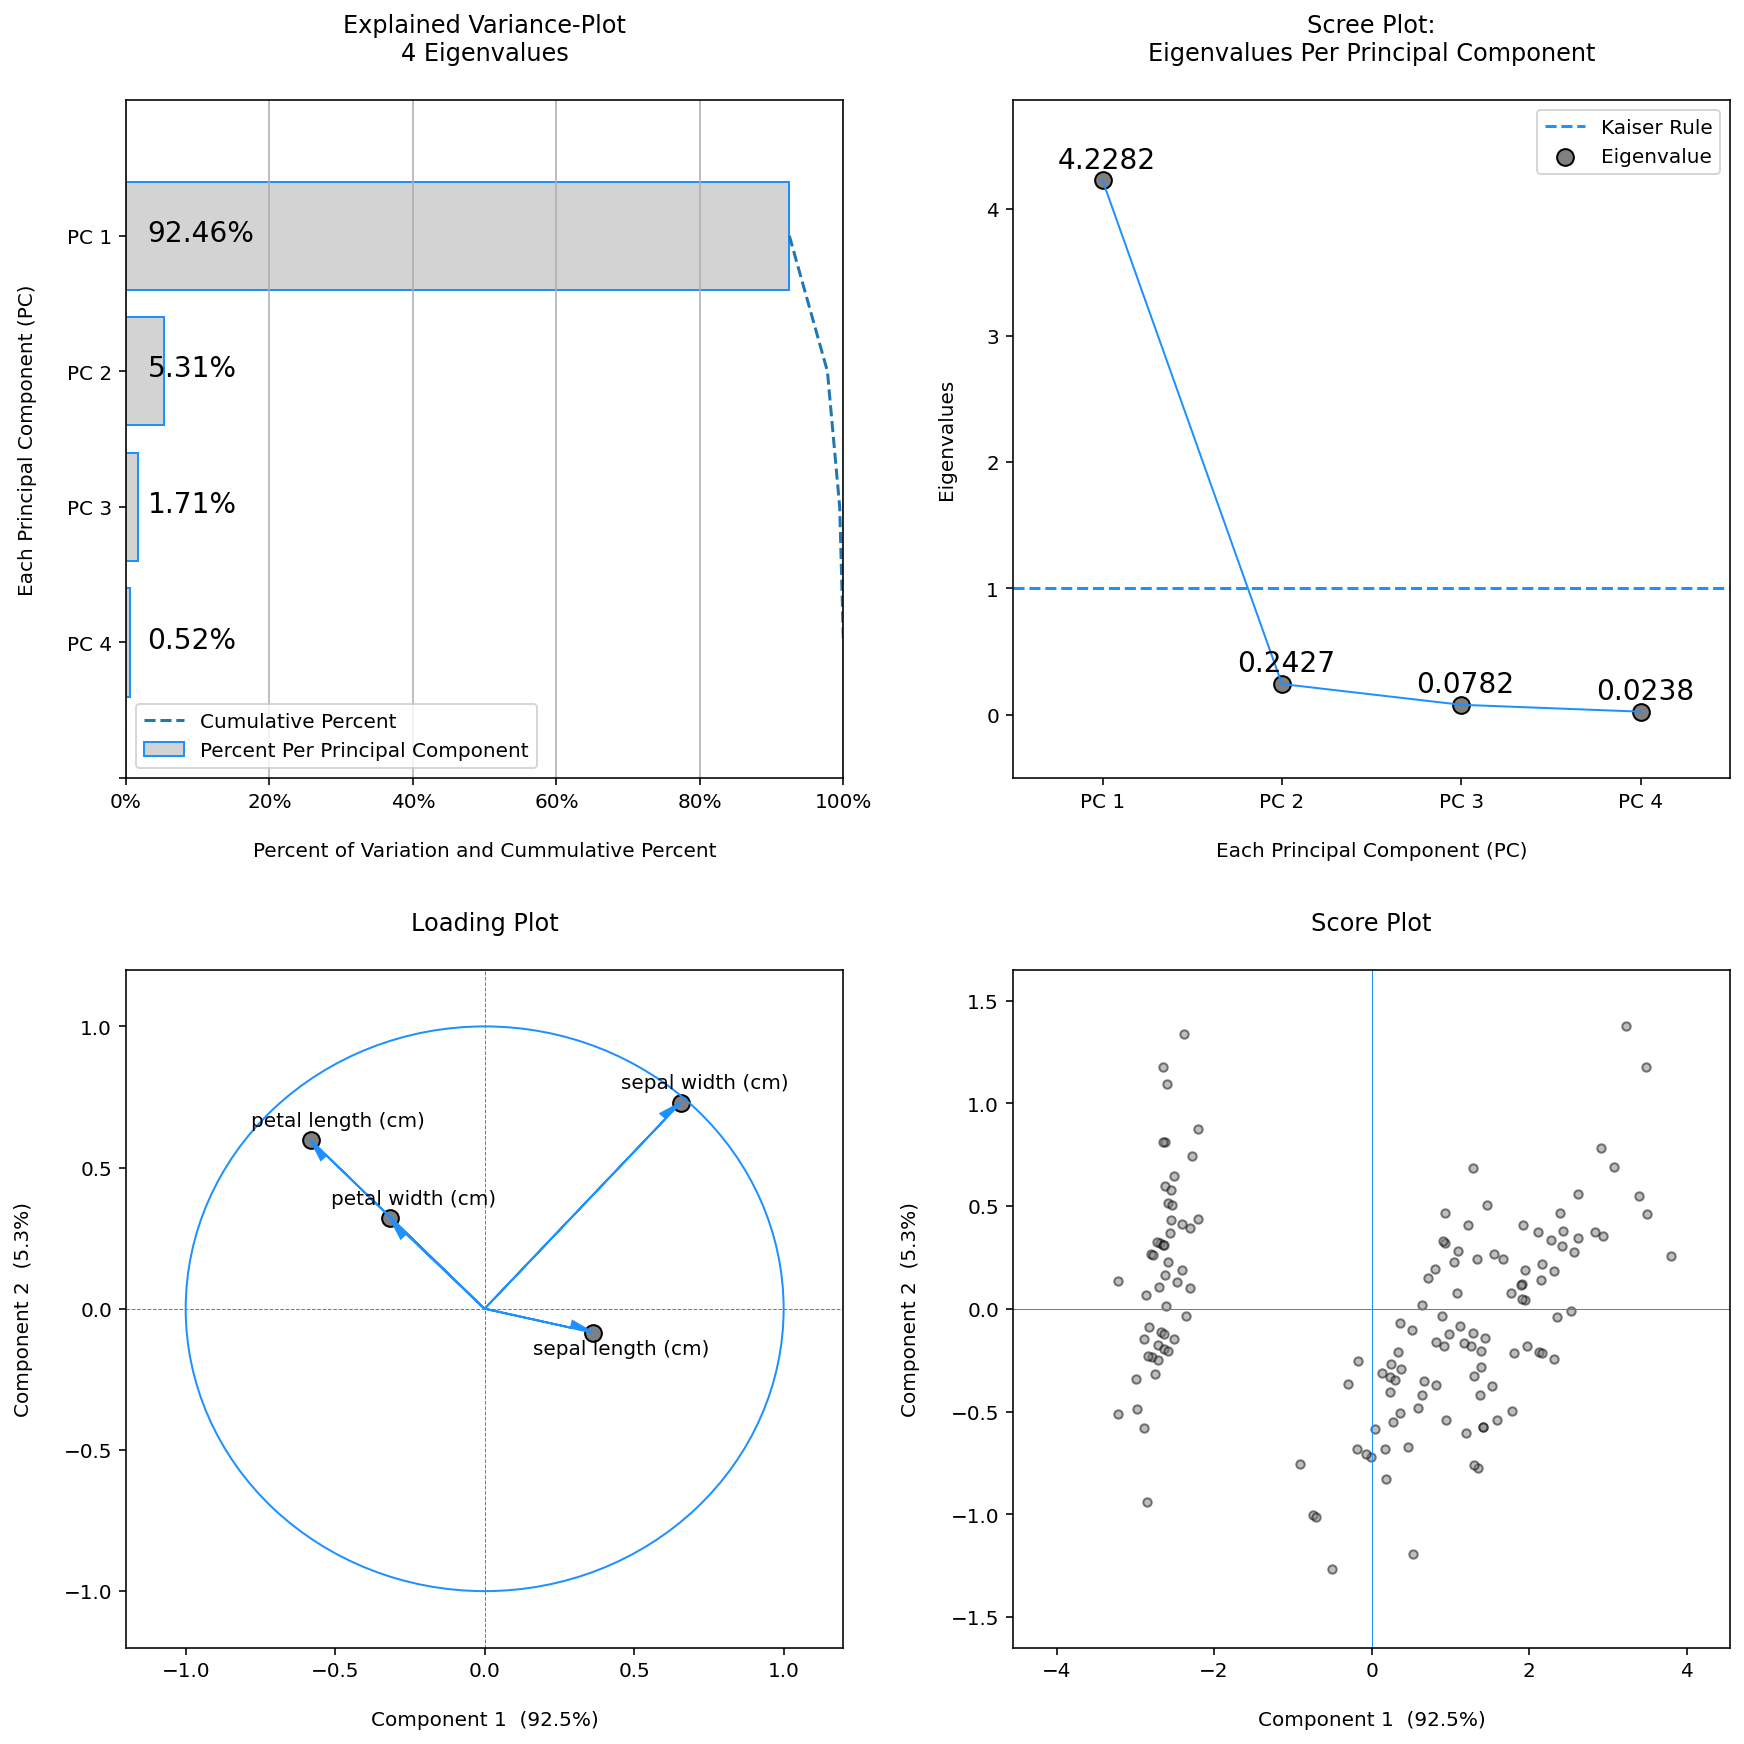


Original Data with Principal Components Added



,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4
0,5.1,3.5,1.4,0.2,-2.684126,0.319397,-0.027915,-0.002262
1,4.9,3.0,1.4,0.2,-2.714142,-0.177001,-0.210464,-0.099027
2,4.7,3.2,1.3,0.2,-2.888991,-0.144949,0.017900,-0.019968
3,4.6,3.1,1.5,0.2,-2.745343,-0.318299,0.031559,0.075576
4,5.0,3.6,1.4,0.2,-2.728717,0.326755,0.090079,0.061259
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1.944110,0.187532,0.177825,-0.426196
146,6.3,2.5,5.0,1.9,1.527167,-0.375317,-0.121898,-0.254367
147,6.5,3.0,5.2,2.0,1.764346,0.078859,0.130482,-0.137001
148,6.2,3.4,5.4,2.3,1.900942,0.116628,0.723252,-0.044595


In [15]:
pca_data = conduct_pca(data)
print('\nOriginal Data with Principal Components Added\n')
display(pca_data)

# Individual Plots Sandbox

## Eigenvalues Matrix

In [16]:
create_eigenvalues_matrix(data)

,eigenvalues,ev_ratios,cum_percent
0,4.228242,0.924619,92.461872
1,0.242671,0.053066,97.768521
2,0.078210,0.017103,99.478782
3,0.023835,0.005212,100.000000


## Covariance Matrix

In [17]:
create_covariance_matrix(data)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),0.685694,-0.042434,1.274315,0.516271
sepal width (cm),-0.042434,0.189979,-0.329656,-0.121639
petal length (cm),1.274315,-0.329656,3.116278,1.295609
petal width (cm),0.516271,-0.121639,1.295609,0.581006


## Eigenvalues Matrix

In [18]:
create_eigenvectors_matrix(data)

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4
sepal length (cm),0.361387,-0.084523,0.856671,0.358289
sepal width (cm),0.656589,0.730161,-0.173373,-0.075481
petal length (cm),-0.582030,0.597911,0.076236,0.545831
petal width (cm),-0.315487,0.319723,0.479839,-0.753657


## Score Plot 

### By Function

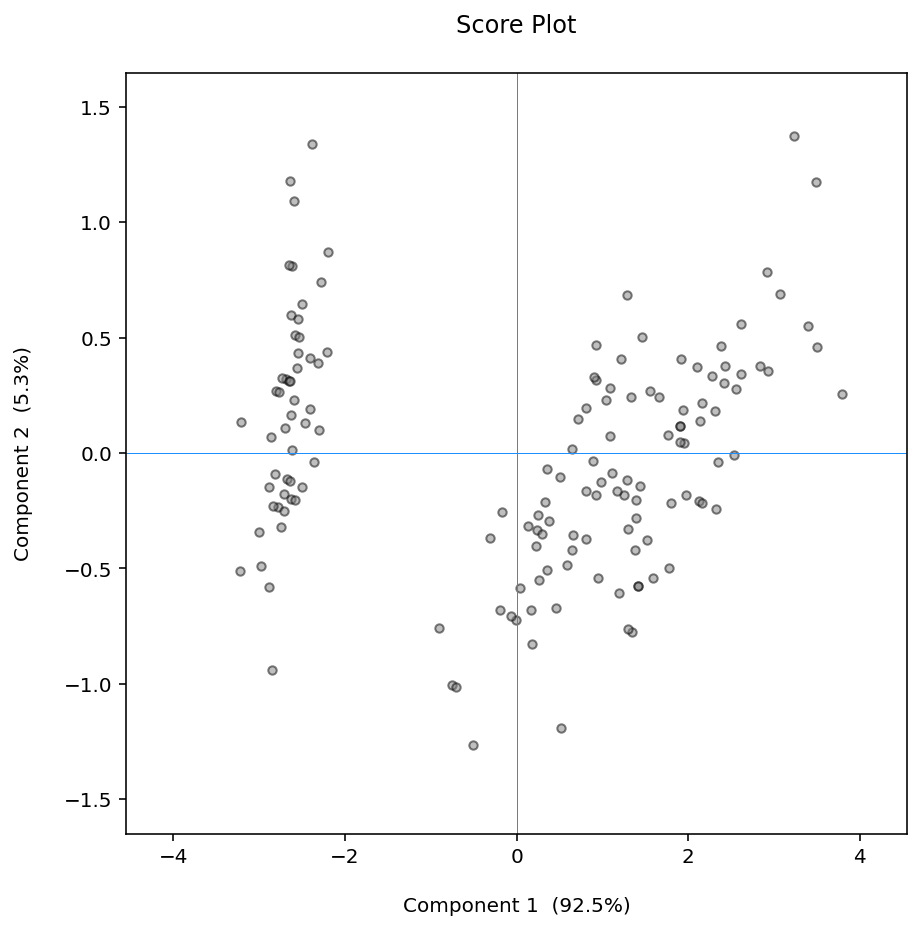

In [19]:
create_pca_score_plot(data, comp_a=1, comp_b=2)

### Original Code

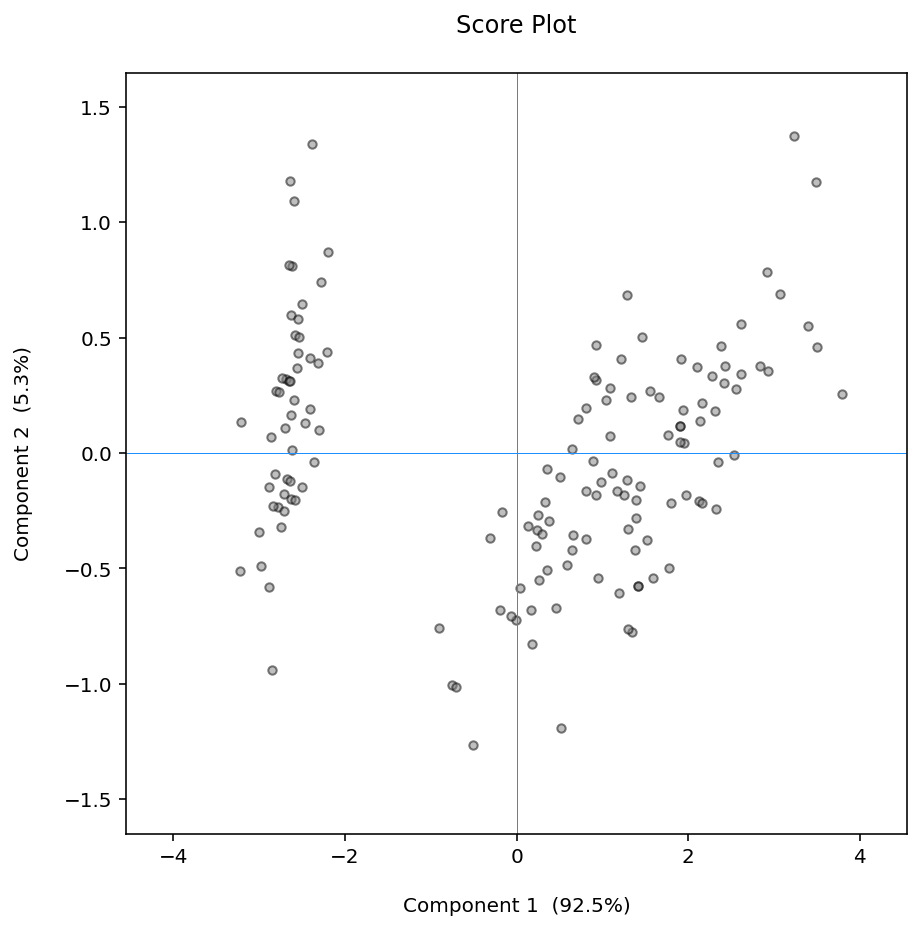

In [20]:
comp_a = 1
comp_b = 2

# Get principal components and eigenvectors
p_components = calculate_principal_components(data)
ev_matrix = create_eigenvalues_matrix(data, styled=False)

# Build plot
fig, ax = plt.subplots(figsize=(7,7))

x_val = p_components[f"Principal Component {comp_a}"]
y_val = p_components[f"Principal Component {comp_b}"]

# Some styles only make sense if the number of points to plot
# are below certain thresholds...
marker = "o" if len(p_components ) < 50 else "."
ax.scatter(x_val, y_val, marker=marker, s = 70, color="grey", ec="k", alpha=0.5, label = 'Data')

# X and Y axis
ax.axhline(y=0, linestyle = '-', color = 'dodgerblue', linewidth = 0.5)
ax.axvline(x=0, linestyle = '-', color = 'dodgerblue', linewidth = 0.5)

# Max/ Min
x_limit = max(abs(x_val.min()), abs(x_val.max()))*1.20
ax.set_xlim(-x_limit, x_limit)
y_limit = max(abs(y_val.min()), abs(y_val.max()))*1.20
ax.set_ylim(-y_limit, y_limit)

# Labels and Title
ax.set_xlabel(f"\nComponent {comp_a}  ({(round(ev_matrix.iloc[comp_a-1]['ev_ratios'],3))*100}%)")
ax.set_ylabel(f"Component {comp_b}  ({(round(ev_matrix.iloc[comp_b-1]['ev_ratios'],3))*100}%)\n")
ax.set_title('Score Plot\n')
plt.show()

## Loading Plot

### By Function

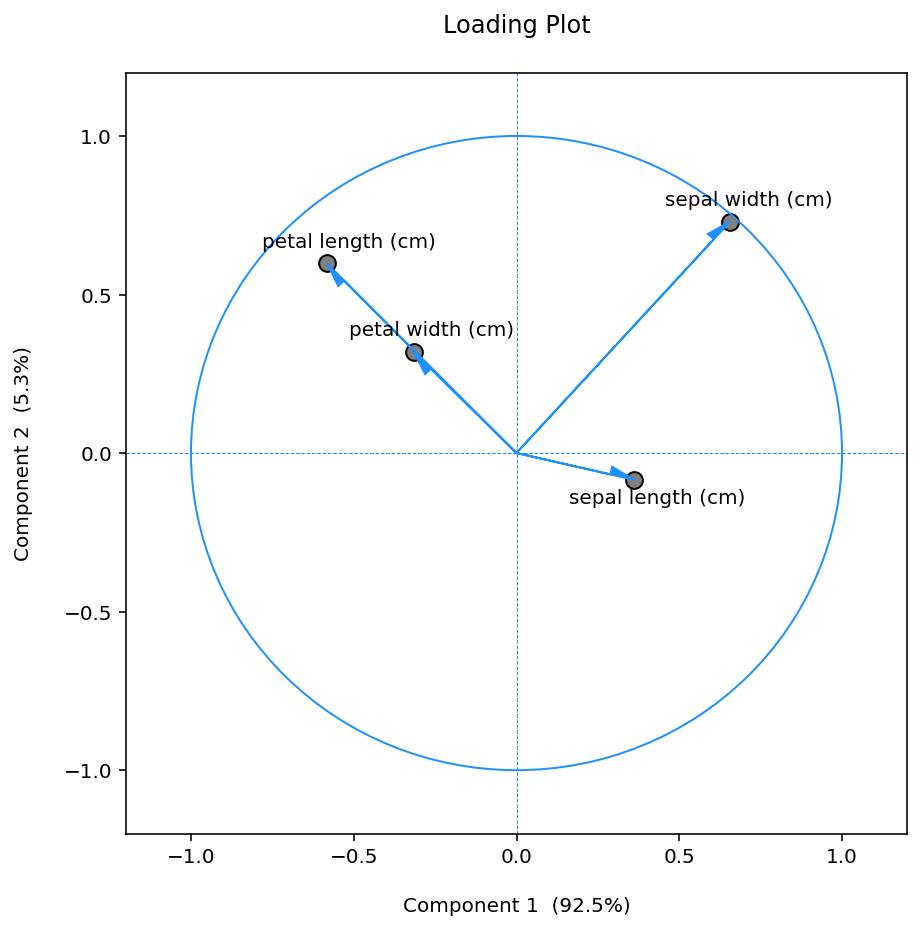

In [21]:
create_pca_loading_plot(data, comp_a=1, comp_b=2)

### Original Code

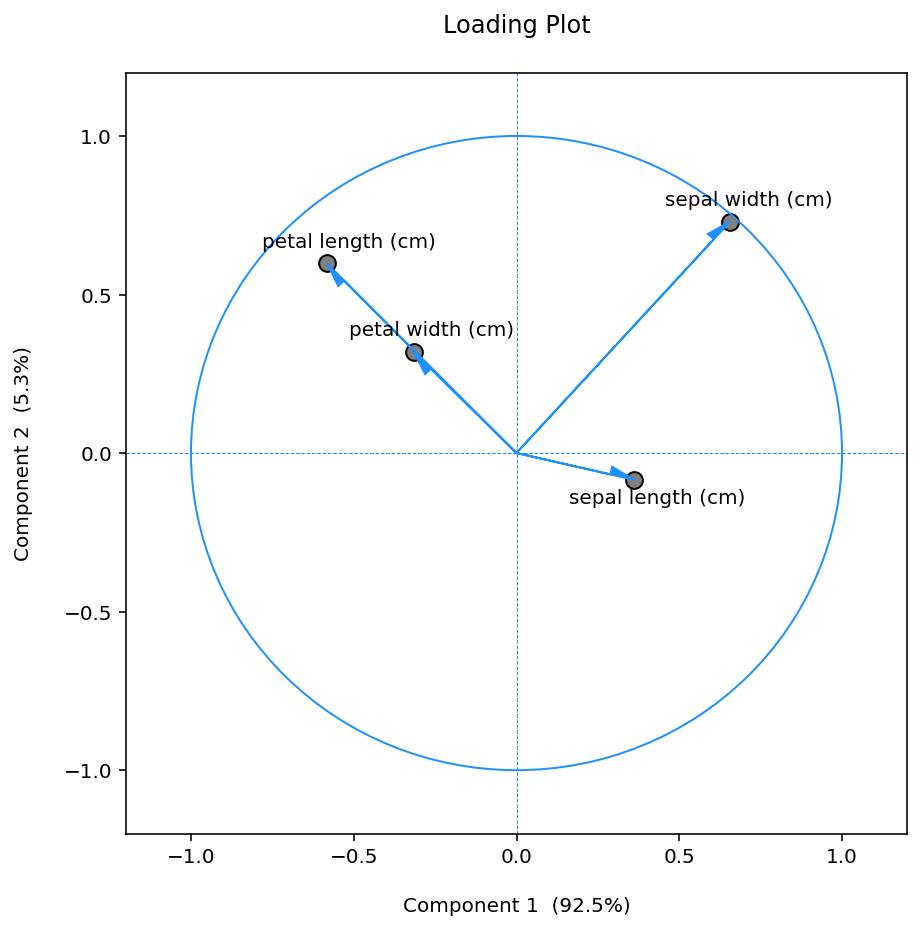

In [22]:
comp_a = 1
comp_b = 2

eigenvectors = create_eigenvectors_matrix(data, styled=False)
ev_matrix = create_eigenvalues_matrix(data, styled=False)

# Build plot
fig, ax = plt.subplots(figsize=(7,7))

eigen_x_val = eigenvectors[f"Principal Component {comp_a}"]
eigen_y_val = eigenvectors[f"Principal Component {comp_b}"]

# Add circle
circ = plt.Circle((0, 0), 1, color='dodgerblue', fill=False)
ax.add_patch(circ)

# X and Y axis
ax.axhline(y=0, linestyle = '--', color = 'dodgerblue', linewidth = 0.5)
ax.axvline(x=0, linestyle = '--', color = 'dodgerblue', linewidth = 0.5)

# Draw arrows and annotate
for i, row in eigenvectors.iterrows():
    
    # plot arrow
    ax.arrow(
        0, 0, 
        row[f"Principal Component {comp_a}"], row[f"Principal Component {comp_b}"], 
        color = 'dodgerblue', 
        length_includes_head = True,
        head_width = 0.05,
        shape = 'right',
        linewidth = 1, 
    )
    
    if row[f"Principal Component {comp_b}"]<=0: vert_adj = -0.075
    else: vert_adj = 0.05
        
    ax.text(
        row[f"Principal Component {comp_a}"]-0.2, row[f"Principal Component {comp_b}"]+vert_adj,
        i
    )
# Scatterplot    
ax.scatter(eigen_x_val, eigen_y_val, marker="o", s = 70, color="grey", ec="k", alpha=1, label = 'Data')

# Max/ Min
ax.set_xlim(-1.20, 1.20)
ax.set_ylim(-1.20, 1.20)

# Labels and Title
ax.set_xlabel(f"\nComponent {comp_a}  ({(round(ev_matrix.iloc[comp_a-1]['ev_ratios'],3))*100}%)")
ax.set_ylabel(f"Component {comp_b}  ({(round(ev_matrix.iloc[comp_b-1]['ev_ratios'],3))*100}%)\n")
ax.set_title('Loading Plot\n')
plt.show()

## Eigenvalue Pareto / Explained Variance Plot

### By Function

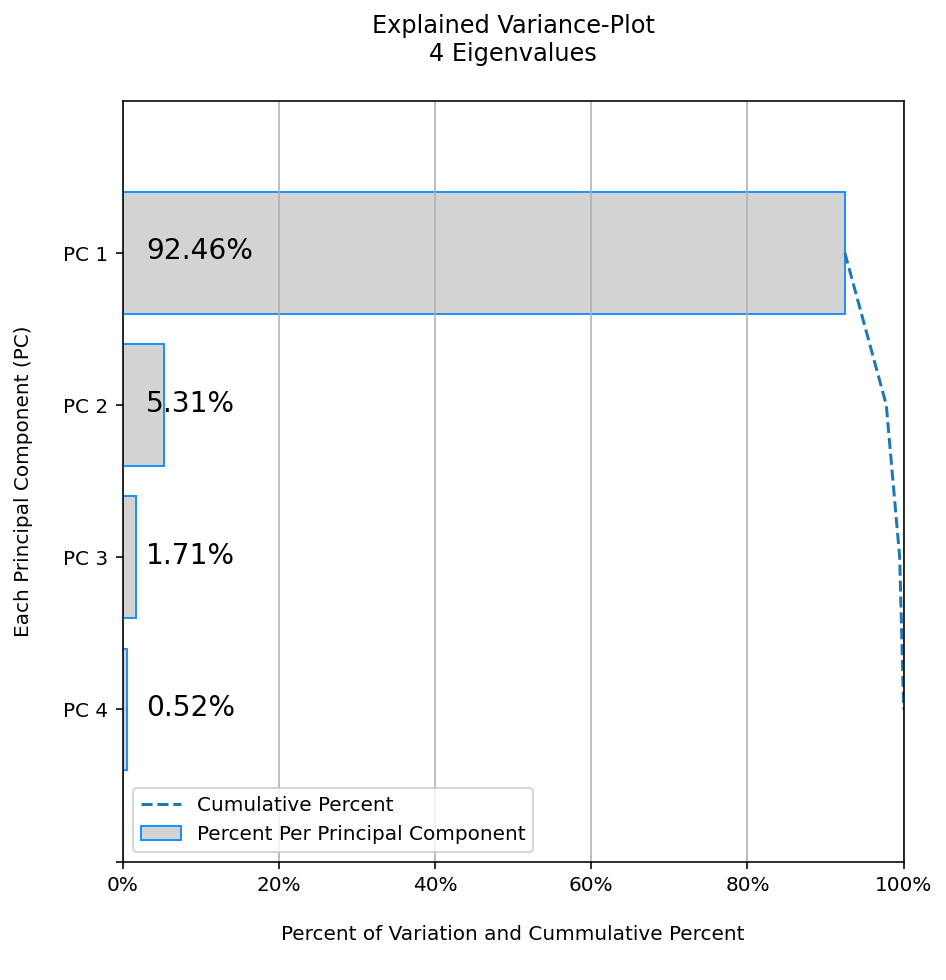

In [23]:
create_pca_explained_variance_plot(data, max_eigenvals=10)

### Original Code

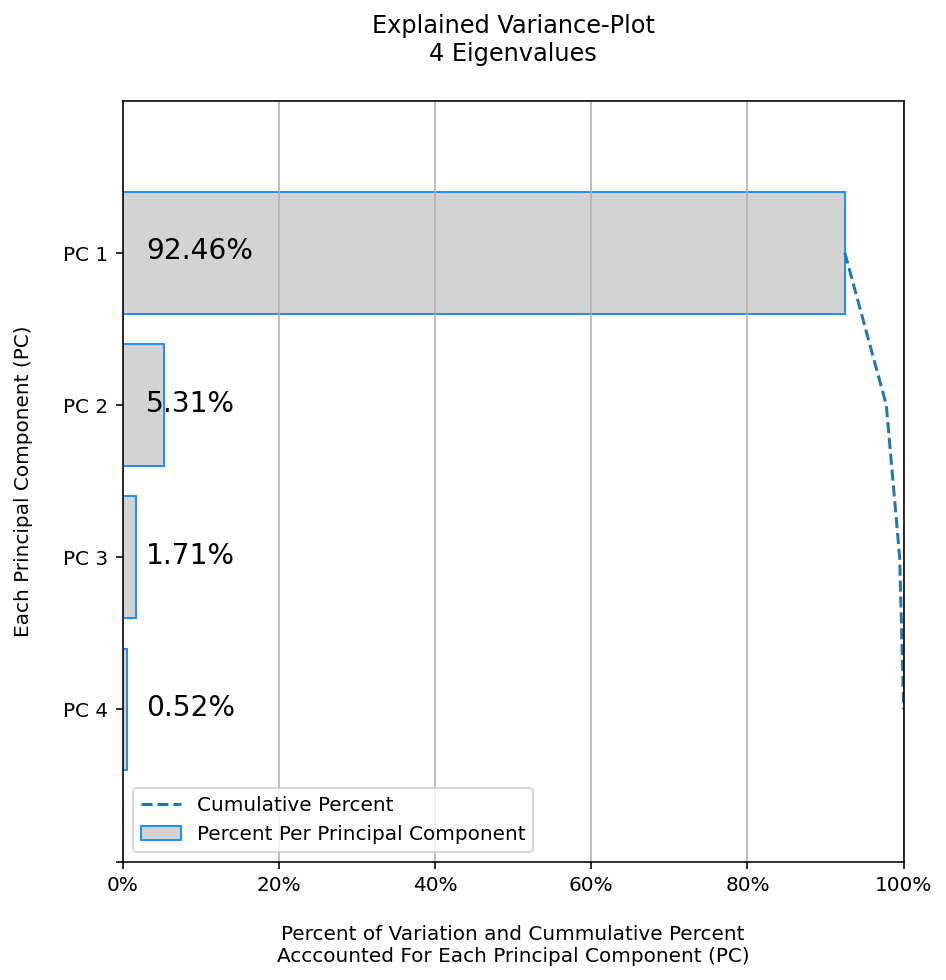

In [24]:
max_eigenvals = 10
ev_matrix = create_eigenvalues_matrix(data, styled=False)

# Set the max number of eigenvalues to show on the Pareto plot
num_eigenvals_to_show = len(ev_matrix)
max_threshold = False

if num_eigenvals_to_show > max_eigenvals:
    max_threshold = True
    num_eigenvals_to_show = max_eigenvals-1

# Build plot
fig, ax = plt.subplots(figsize=(7,7))

# Get the most recent values for a bar plot up to the max eigenvalues
eigenvalues = ev_matrix['eigenvalues'][0:(num_eigenvals_to_show + 1)].sort_values(ascending=False)  # only take the first 10 eigenvalues
ev_ratios = ev_matrix['ev_ratios'][0:(num_eigenvals_to_show + 1)].sort_values(ascending=False)*100
cum_percent = ev_matrix['cum_percent'][0:(num_eigenvals_to_show + 1)].sort_values(ascending=True)

# Append missing values if there are less than '(num_eigenvals_to_show + 1)'
if (num_eigenvals_to_show + 1)-len(eigenvalues) > 0:
    
    blank_vals = list(np.full((1,(num_eigenvals_to_show + 1)-len(eigenvalues)), fill_value = '')[0])
    y_labels = round(ev_ratios,2).append(pd.Series(blank_vals))
    y_labels =[f'{val}%' if '' != val else '' for val in y_labels]

    zero_vals = list(np.full((1,(num_eigenvals_to_show + 1)-len(eigenvalues)), fill_value = 0)[0])
    y_nums = ev_ratios.append(pd.Series(zero_vals))

y_vals = np.arange((num_eigenvals_to_show + 1)-1,-1,-1)

# Make the bar plot, cumulative percentage plots, etc. 
ax.barh(y_vals, y_nums[0:len(y_vals)], align='center', color = 'lightgrey', edgecolor = 'dodgerblue', alpha=1, label = 'Percent Per Principal Component')
ax.plot(cum_percent, y_vals[:len(cum_percent)], linestyle = '--', label = 'Cumulative Percent')

# X Axis Ticker Format
fmt = '{x:,.0f}%'
tick = mpl.ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

# X limit
ax.set_xlim(0,100)

# Title changes to alert user of missing eigenvalues if the max threshold is less than the number eigenvalues available. 
if max_threshold:  # missing eigenvalues because there are more than the max threshold
    not_shown = len(ev_matrix)-max_eigenvals
    ax.set_title(f'Explained Variance-Pareto Plot\n{num_eigenvals_to_show+1} Eigenvalues\n{not_shown} Eigenvalue(s) not displayed.\n')
    ax.set_ylim(-1,(num_eigenvals_to_show + 1))
    
else:
    ax.set_title(f'Explained Variance-Plot\n{num_eigenvals_to_show} Eigenvalues\n') 
    ax.set_ylim(0,(num_eigenvals_to_show + 1))

ax.set_xlabel('\nPercent of Variation and Cummulative Percent\nAcccounted For Each Principal Component (PC)')

# Set Y values and tick lables
ax.set_ylabel(f'Each Principal Component (PC)\n')
ax.set_yticks(y_vals)

# Make sure to label the principal components corresponding to the Eigenvalues
new_y_labels = []
for count in range(1, len(y_labels)+1):
    new_val = f'PC {count}'
    
    if count == len(y_labels):
        new_y_labels.append('')
    else:
        new_y_labels.append(new_val)
    ax.text(3,count-0.04, y_labels[len(y_labels)-count-1], fontsize = 14)
    
ax.set_yticklabels(new_y_labels[0:len(y_vals)])
ax.grid(axis="x")
ax.legend(loc = 3)
plt.show()

## Scree Plot

### By Function

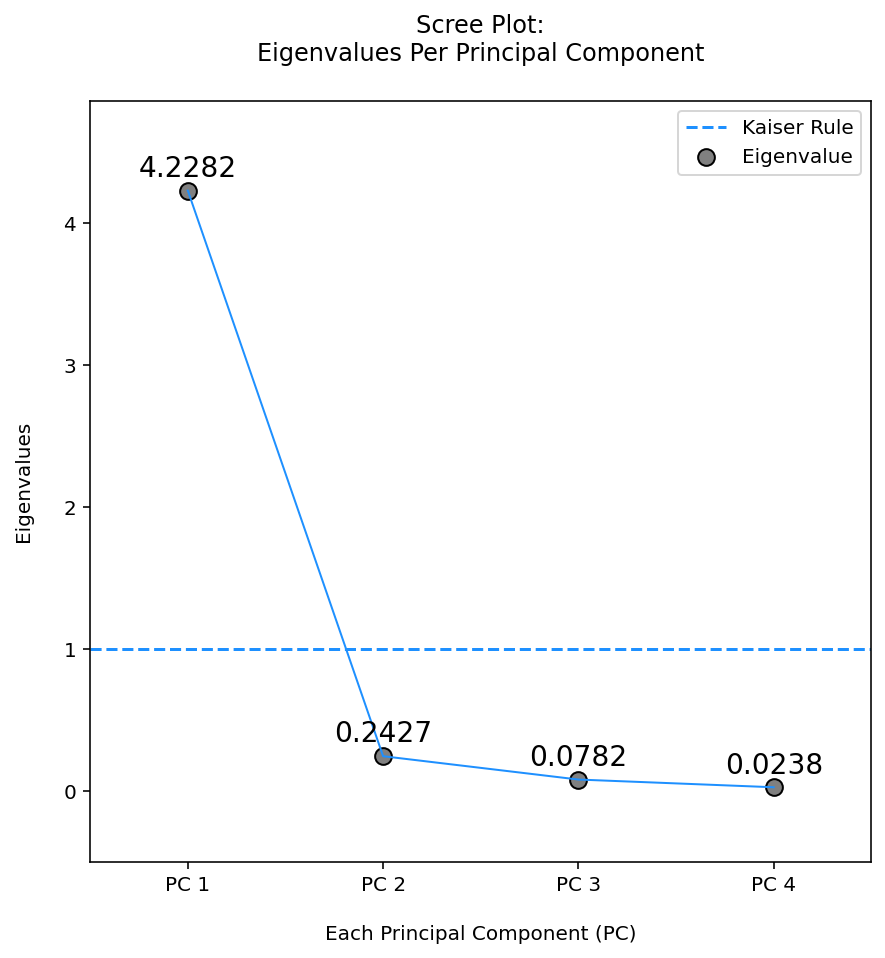

In [25]:
create_pca_scree_plot(data, max_eigenvals = 10)

### Original Code

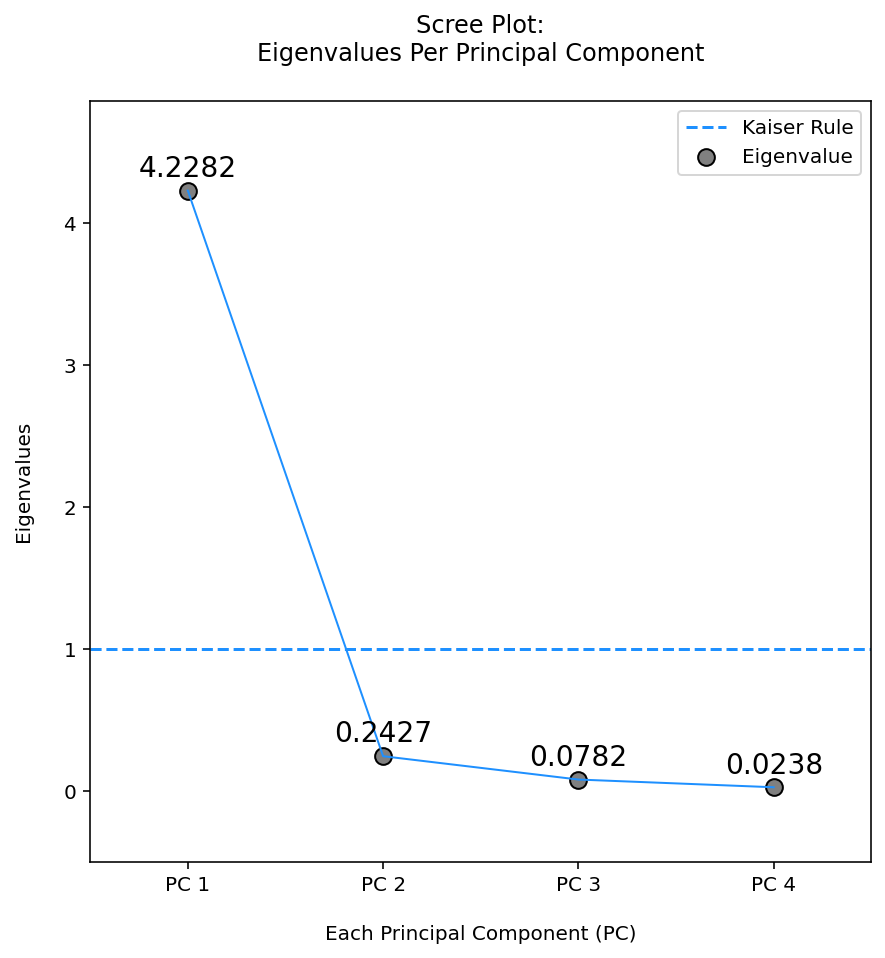

In [26]:
max_eigenvals = 10

# Get principal Components
pca = PCA()
p_components = pca.fit_transform(data)

# Explained Variance (Eigenvalues)
eigenvalues = pca.explained_variance_

# Build plot
fig, ax = plt.subplots(figsize=(7,7))

# Some styles only make sense if the number of points to plot
# are below certain thresholds...
marker = "o" if len(eigenvalues) < 50 else "."
ax.scatter(
    np.arange(0,(len(eigenvalues)))[0:max_eigenvals], 
    eigenvalues[0:max_eigenvals],
    marker=marker, 
    s = 70, 
    color="grey", ec="k", alpha=1, 
    label = 'Eigenvalue'
)
ax.plot(eigenvalues[0:max_eigenvals], color = 'dodgerblue', linewidth = 1)

# Plot Eigenvalues

for i in range(0,len(eigenvalues)):
    val = round(eigenvalues[i],4)
    text_loc_y = val+0.1
    text_loc_x = i-0.25
    ax.text(text_loc_x, text_loc_y, val, fontsize = 14)

ax.axhline(y=1, color = 'dodgerblue', linestyle = '--', label='Kaiser Rule')
ax.set_ylim(-0.5, np.max(eigenvalues)*1.15)
ax.set_xlim(-0.5, len(eigenvalues)-0.5)

ax.set_title('Scree Plot:\nEigenvalues Per Principal Component\n')
ax.set_ylabel('Eigenvalues\n')
ax.set_xlabel('\nEach Principal Component (PC)')

ax.set_xticks(np.arange(0, len(eigenvalues))[0:max_eigenvals])
ax.set_xticklabels([f'PC {val}' for val in np.arange(1,len(eigenvalues)+1)][0:max_eigenvals])
ax.legend()
plt.show()


## Bi-Plot

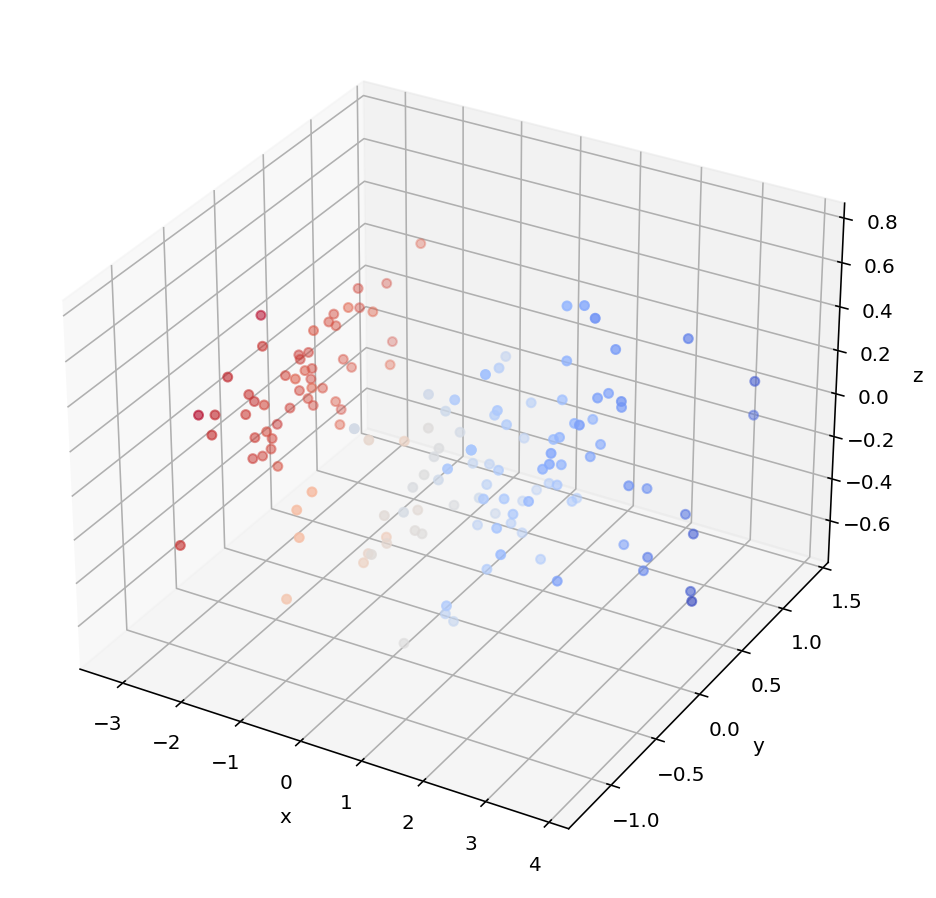

In [27]:
comp_a = 1
comp_b = 2
comp_c = 3

# Get principal components and eigenvectors
p_components = calculate_principal_components(data)

x_val = p_components[f"Principal Component {comp_a}"]
y_val = p_components[f"Principal Component {comp_b}"]
z_val = p_components[f"Principal Component {comp_c}"]

#fig,ax = plt.subplots(1,1, figsize=(5,5))
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(x_val,y_val,z_val, marker = 'o', c=x_val, cmap=mpl.cm.coolwarm_r)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()